# Surface Crack Prediction

In [1]:
# Required modules

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from zipfile import ZipFile
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 7)

In [32]:
# Dividing into train and validation split

img_h = 300
img_w = 300

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255.,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.5
)

train = datagen.flow_from_directory(
    r"D:\sem 03\ML Project\crack_detection\data\train",
    seed = 88,
    subset = 'training',
    batch_size = 32
)

valid = datagen.flow_from_directory(
    r"D:\sem 03\ML Project\crack_detection\data\validation",
    seed = 88,
    subset = 'validation',
,   batch_size = 32
)

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [33]:
conv_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(input_shape=(img_h, img_w, 3), filters=32, padding='same', kernel_size=3, activation='swish'),
    tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='swish'),
    tf.keras.layers.Conv2D(filters=128, padding='same', kernel_size=3, activation='swish'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=3, activation='swish'),
    tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=3, activation='swish'),
    tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=3, activation='swish'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='swish'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax'),
])

In [34]:
# Pre-trained model

in_layer = tf.keras.layers.Input(shape=(None, None, 3))
xception = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_tensor=in_layer)

for layer in xception.layers:
    layer.trainable = False

inter = tf.keras.layers.GlobalMaxPooling2D()(xception.output)
flatten = tf.keras.layers.Flatten()(inter)
dense1 = tf.keras.layers.Dense(512, activation='relu')(flatten)
dense2 = tf.keras.layers.Dense(256, activation='relu')(dense1)
dense3 = tf.keras.layers.Dense(128, activation='relu')(dense2)
output = tf.keras.layers.Dense(2, activation='softmax')(dense3)

xception = tf.keras.models.Model(inputs=xception.inputs, outputs=output)

## For the pre-trained model
https://dockship.io/notebooks/60ba40b67354863913633025/boat-type-classification-ai-challenge-peddi-anurag-notebook
https://data-science-blog.com/blog/2022/04/11/how-to-choose-the-best-pre-trained-model-for-your-convolutional-neural-network/
https://medium.com/@draj0718/image-classification-and-prediction-using-transfer-learning-3cf2c736589d

In [35]:
model = xception

In [36]:
initial_lr = 0.01


lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=25,
    decay_rate=0.96,
    staircase=True
)

In [37]:
# Defining callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=10, verbose=0)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_weights.hdf5', monitor='val_acc', mode='max', save_weights_only=True, verbose=0)

callbacks = [checkpoint, early_stopping]


In [38]:
# Defining optimizer and loss functions

#optim = tf.keras.optimizers.RMSprop(learning_rate=lr_scheduler)
optim = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
loss_funct = 'CategoricalCrossentropy'

model.compile(optimizer=optim, loss=loss_funct, metrics=['acc'])

In [39]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_4[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                         

In [41]:
# Fitting on the training data

epochs = 13
batch_size = 64

history = model.fit(train, validation_data=valid, epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Epoch 1/13
469/469 [==============================] - 1432s 3s/step - loss: 0.0458 - acc: 0.9908 - val_loss: 0.0234 - val_acc: 0.9918
Epoch 2/13
469/469 [==============================] - 1437s 3s/step - loss: 0.0140 - acc: 0.9959 - val_loss: 0.0202 - val_acc: 0.9950
Epoch 3/13
469/469 [==============================] - 1603s 3s/step - loss: 0.0095 - acc: 0.9976 - val_loss: 0.0131 - val_acc: 0.9952
Epoch 4/13
469/469 [==============================] - 1842s 4s/step - loss: 0.0071 - acc: 0.9979 - val_loss: 0.0182 - val_acc: 0.9938
Epoch 5/13
469/469 [==============================] - 1533s 3s/step - loss: 0.0063 - acc: 0.9983 - val_loss: 0.0181 - val_acc: 0.9954
Epoch 6/13
469/469 [==============================] - 1551s 3s/step - loss: 0.0059 - acc: 0.9981 - val_loss: 0.0133 - val_acc: 0.9958
Epoch 7/13
469/469 [==============================] - 1399s 3s/step - loss: 0.0059 - acc: 0.9981 - val_loss: 0.0173 - val_acc: 0.9950
Epoch 8/13
469/469 [==============================] - 1808s 4s

In [43]:
tf.keras.models.save_model(model,'model_xception.hdf5')

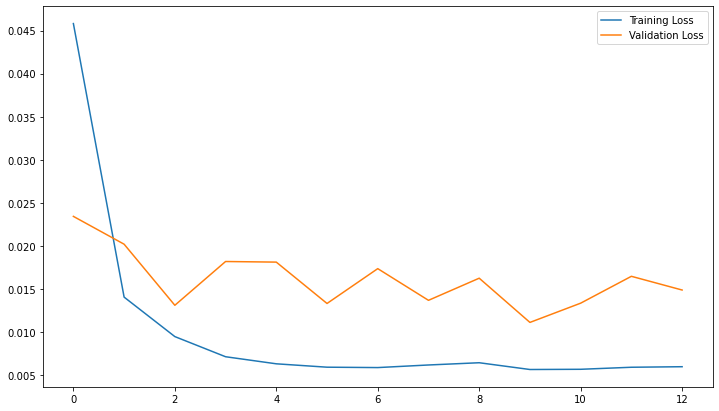

In [44]:
# Plotting Loss

plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.legend()

In [46]:
print(history.history['acc'][12])
print(history.history['val_acc'][12])

0.9980666637420654
0.9954000115394592


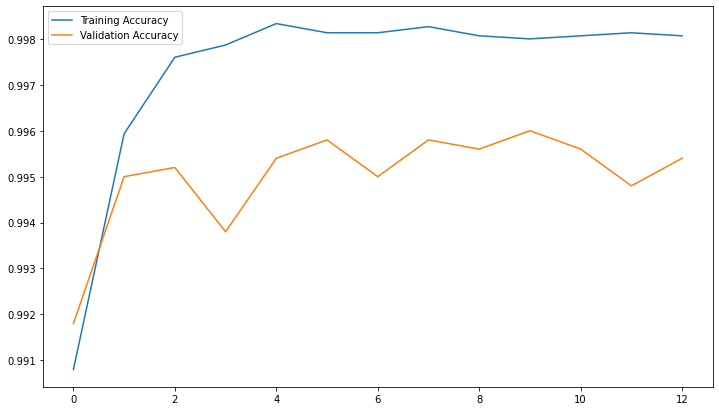

In [47]:
# Plotting Accuracy

x_axis = range(epochs)

plt.plot(history.epoch, history.history['acc'], label='Training Accuracy')
plt.plot(history.epoch, history.history['val_acc'], label='Validation Accuracy')
plt.legend()

In [48]:
# Loading the best model

model.load_weights('model_weights.hdf5')

In [59]:
test_data_gen = datagen.flow_from_directory(
    r"D:\sem 03\ML Project\crack_detection\data\validation",
   
    seed = 88,
    subset = 'validation',
#     target_size = (img_h, img_w),
    batch_size = 32
)

Found 5000 images belonging to 2 classes.
